## Codebook
<br>

[Ссылка для скачивания данных](https://drive.google.com/open?id=1dPCG76ST6NohYKtVMGv6HpFL-jD5p1eJ)
<br><br>

`telecom_users.csv` содержит следующие значения:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `customerID` – id клиента<br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` – пол клиента (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` – яляется ли клиент пенсионером (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – состоит ли клиент в браке (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` – есть ли у клиента иждивенцы (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – сколько месяцев человек являлся клиентом компании<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – подключена ли услуга телефонной связи (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – подключены ли несколько телефонных линий (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – интернет-провайдер клиента (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – подключена ли услуга онлайн-безопасности (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – подключена ли услуга online backup (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – есть ли у клиента страховка оборудования (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` – подключена ли услуга технической поддержки (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – подключена ли услуга стримингового телевидения (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – подключена ли услуга стримингового кинотеатра (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – тип контракта клиента (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – пользуется ли клиент безбумажным биллингом (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – метод оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges` – месячный размер оплаты на настоящий момент<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` – общая сумма, которую клиент заплатил за услуги за все время<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` – произошел ли отток (Yes or No)<br>

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix


In [114]:
#GLOBAL
RANDOM_SEED = 17
VAL_SIZE   = 0.3   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 6000
LR         = 0.01


In [115]:
df = pd.read_csv('./data/telecom_users.csv')
df = df[df.columns[2:]]
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
Y = df['Churn'].copy()
df = df.drop('Churn', axis=1)
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [116]:
df.select_dtypes(include=['object']).nunique().max()

4

In [117]:
cat_columns = df.select_dtypes(include=['object']).columns
num_columns = df.select_dtypes(include=['number']).columns

In [118]:
df_main = pd.get_dummies(df, prefix=cat_columns)
sc = StandardScaler()
df_main[num_columns] = sc.fit_transform(df[num_columns])
df_main.columns = map(lambda x: x.lower(), df_main.columns)
df_main.head(5)

,tenure,monthlycharges,totalcharges,gender_female,gender_male,seniorcitizen_0,seniorcitizen_1,partner_no,partner_yes,dependents_no,...,streamingmovies_yes,contract_month-to-month,contract_one year,contract_two year,paperlessbilling_no,paperlessbilling_yes,paymentmethod_bank transfer (automatic),paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check
0,1.611381,-1.353483,-0.247769,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,0.468468,0.774066,0.736669,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.223558,0.335602,0.251453,1,0,0,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
3,-1.164265,-0.297182,-0.905725,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
4,-1.245901,-0.378564,-0.958057,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [119]:
Y.value_counts(normalize=True)

0    0.734438
1    0.265562
Name: Churn, dtype: float64

In [120]:
x_train, x_test, y_train, y_test = train_test_split(df_main, Y, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=Y, shuffle=True)

In [123]:
def eval_model(model, x_test, y_test):
    print('Accurace score: {}'.format(accuracy_score(
        y_test, model.predict(x_test)
    )))
    print('Точность: {}'.format(precision_score(y_test, model.predict(x_test))))
    print('Полнота: {}'.format(recall_score(y_test, model.predict(x_test))))
    print('F1 Score: {}'.format(f1_score(y_test, model.predict(x_test))))
    print('Roc_Auc Score: {}'.format(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])))
    plot_confusion_matrix(model, x_test, y_test)
    plot_roc_curve(model, x_test, y_test)
    plt.show()

Accurace score: 0.800334634690463
Точность: 0.6512820512820513
Полнота: 0.5336134453781513
F1 Score: 0.5866050808314087
Roc_Auc Score: 0.843698755128475


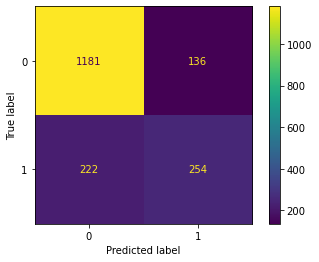

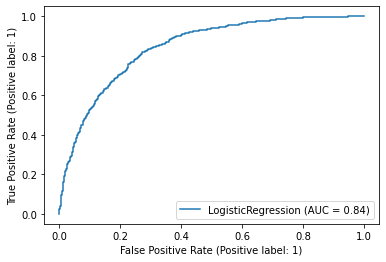

In [124]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1')
log_reg.fit(x_train, y_train)
eval_model(log_reg, x_test, y_test)

Accurace score: 0.7791411042944786
Точность: 0.5909090909090909
Полнота: 0.5462184873949579
F1 Score: 0.5676855895196506
Roc_Auc Score: 0.807423766773224


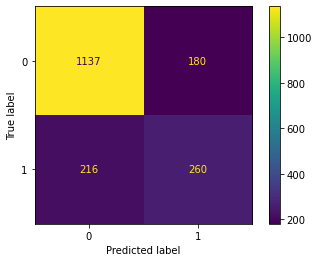

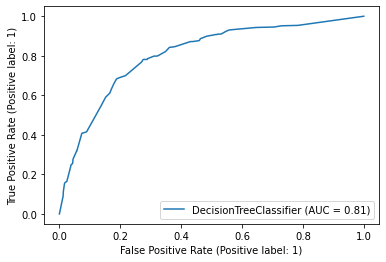

In [125]:
dtc = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=7, min_samples_split=5)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
eval_model(dtc, x_test, y_test)

Accurace score: 0.8081427774679308
Точность: 0.6987951807228916
Полнота: 0.48739495798319327
F1 Score: 0.5742574257425742
Roc_Auc Score: 0.8478302482724297


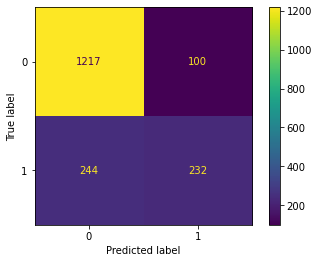

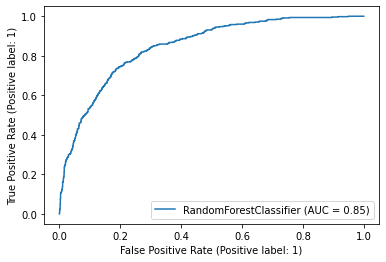

In [126]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED, criterion='gini', max_depth=7, max_features='auto')
rfc.fit(x_train, y_train)
eval_model(rfc, x_test, y_test)

In [127]:
cbc = CatBoostClassifier(iterations=ITERATIONS,
                         learning_rate=LR,
                         random_seed=RANDOM_SEED,
                         depth=10,
                         eval_metric='PRAUC',
                         custom_metric=['AUC', 'Recall'],
                         task_type='CPU',
                         bagging_temperature=1,
                         random_strength=0.5)

In [128]:
df[num_columns] = sc.fit_transform(df[num_columns])

In [129]:
cat_features_ids = np.where(df.apply(pd.Series.nunique) < 5)[0].tolist()

In [130]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED, stratify=Y)

In [131]:
cbc.fit(x_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(x_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6447109	test: 0.5923900	best: 0.5923900 (0)	total: 10.8ms	remaining: 1m 4s
100:	learn: 0.7695959	test: 0.6547701	best: 0.6547701 (100)	total: 919ms	remaining: 53.7s
200:	learn: 0.8308133	test: 0.6576216	best: 0.6589717 (175)	total: 1.85s	remaining: 53.4s
300:	learn: 0.8622263	test: 0.6574873	best: 0.6589717 (175)	total: 2.83s	remaining: 53.7s
400:	learn: 0.8800978	test: 0.6568534	best: 0.6589717 (175)	total: 3.8s	remaining: 53s
500:	learn: 0.8962572	test: 0.6557250	best: 0.6589717 (175)	total: 4.78s	remaining: 52.5s
600:	learn: 0.9106741	test: 0.6550429	best: 0.6589717 (175)	total: 5.69s	remaining: 51.1s
700:	learn: 0.9266618	test: 0.6545373	best: 0.6589717 (175)	total: 6.66s	remaining: 50.3s
800:	learn: 0.9416502	test: 0.6512565	best: 0.6589717 (175)	total: 7.65s	remaining: 49.6s
900:	learn: 0.9520945	test: 0.6493592	best: 0.6589717 (175)	total: 8.66s	remaining: 49s
1000:	learn: 0.9608857	test: 0.6473131	best: 0.6589717 (175)	total: 9.67s	remaining: 48.3s
1100:	learn: 0.96

In [133]:
cbc.save_model('./cbc_model.model')

Accurace score: 0.800334634690463
Точность: 0.6676136363636364
Полнота: 0.49369747899159666
F1 Score: 0.567632850241546
Roc_Auc Score: 0.8421155478136586


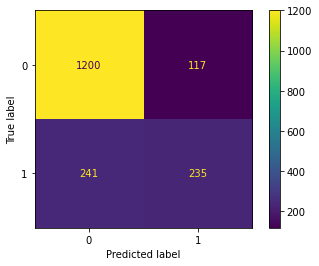

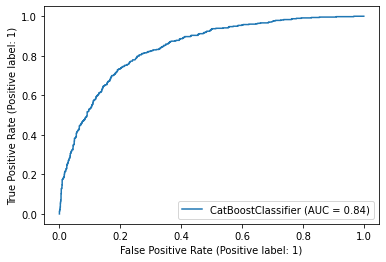

In [132]:
eval_model(cbc, x_test, y_test)